In [2]:
pip install tensorflow-addons

     |████████████████████████████████| 706kB 7.5MB/s 


In [3]:
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [4]:
print("tensorflow version:", tf.__version__)
print("tfa version:", tfa.__version__)

tensorflow version: 2.4.1
tfa version: 0.12.1


# Split Data


In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.16666, random_state=42)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validation samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 validation samples
10000 test samples


In [6]:
def create_pairs(x, digit_indices):
    """ Positive and negative pair creation.
        Alternates between positive and negative pairs.
    """
    pairs = []
    labels = []
    n = min([len(digit_indices[number]) for number in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]  # positive pairs
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)  # take random different digit 
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]  # random negative pairs
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [7]:
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_val == i)[0] for i in range(10)]
val_pairs, val_y = create_pairs(x_val, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [8]:
print(tr_pairs.shape)
print(tr_pairs[0][0].shape)

(90020, 2, 28, 28, 1)
(28, 28, 1)


# Visualize image

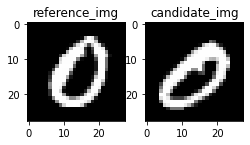

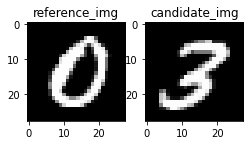

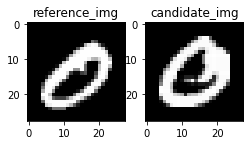

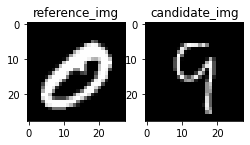

In [9]:
# plt.title('Label is {label}'.format(label=label))

plt.figure()
title = ["reference_img", "candidate_img"]

for row in range(4):
  for i in [1,2]:
    plt.subplot(1, 3, i)
    plt.imshow(tr_pairs[row][i-1].reshape(28,28), cmap='gray')  # plot the pair
    plt.title(title[i-1])
  plt.show()

# Siamese + Logloss

In [10]:
import tensorflow as tf
import math


EPSILON = tf.keras.backend.epsilon()


def l1_distance(vector_pair): 
    x, y = vector_pair
    return tf.norm(x - y, ord=1, axis=1, keepdims=True)

def l2_distance(vector_pair):
    x, y = vector_pair
    return tf.norm(x - y, ord=2, axis=1, keepdims=True)

def cosine_distance(vector_pair):

    x, y = vector_pair

    cos_sim = tf.reduce_sum(
        tf.multiply(
            x,
            y),
#             tf.math.l2_normalize(x, axis=1), 
#             tf.math.l2_normalize(y, axis=1)), 
        axis=1,
        keepdims=True)
    
    cos_sim = tf.clip_by_value(cos_sim, -1.0, 1.0)
    return 1 - cos_sim

## Model 1
- with flattened max-pooling


In [11]:
def cosine_distance(vector_pair):
    x, y = vector_pair
    cos_sim = tf.reduce_sum(
        tf.multiply(
            # x,
            # y),
            tf.math.l2_normalize(x, axis=1), 
            tf.math.l2_normalize(y, axis=1)), 
        axis=1,
        keepdims=True)
    
    cos_sim = tf.clip_by_value(cos_sim, -1.0, 1.0)
    return 1 - cos_sim

In [12]:
image_1 = keras.Input(shape=(28, 28, 1), name="img1")
image_2 = keras.Input(shape=(28, 28, 1), name="img2")

feature_extractor = keras.Sequential(
    [
        # keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

ref_representation = feature_extractor(image_1)
cand_representation = feature_extractor(image_2)

Cosine_layer = tf.keras.layers.Lambda(cosine_distance, name='cosine_distance')
Cosine_distance = Cosine_layer([cand_representation, ref_representation])

outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        )(Cosine_distance)

model = tf.keras.Model(
    inputs= [image_1, image_2], 
    outputs=outputs,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img2 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
img1 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10)           34826       img1[0][0]                       
                                                                 img2[0][0]                       
__________________________________________________________________________________________________
cosine_distance (Lambda)        (None, 1)            0           sequential[1][0]             

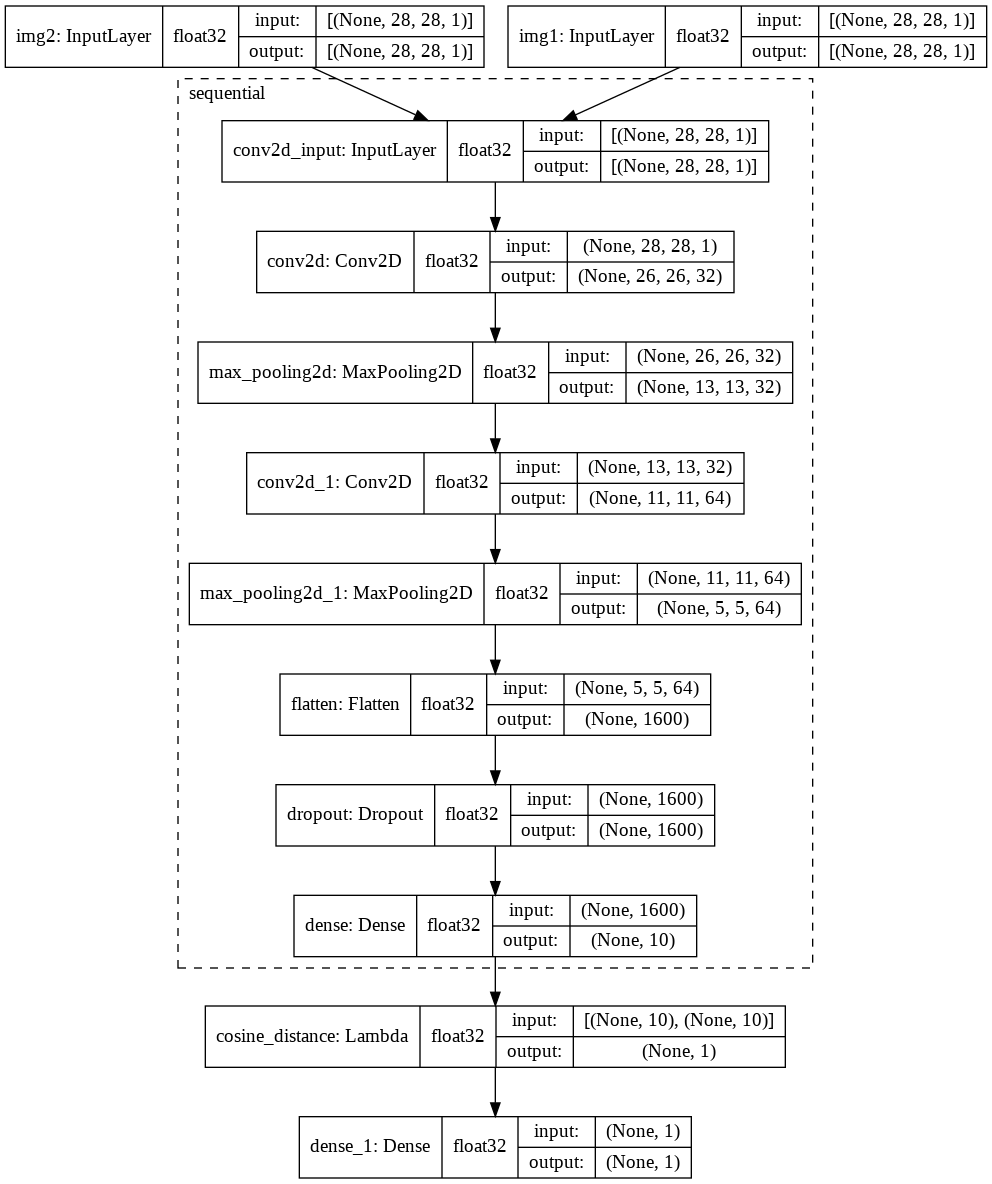

In [13]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [29]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),  # clipnorm to avoid gradient explotion
    loss="binary_crossentropy",
    # metrics="accuracy"
    metrics=tf.keras.metrics.Accuracy(name="acc")
)

In [15]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/15
704/704 [==============================] - 39s 9ms/step - loss: 0.6948 - train_acc: 0.0000e+00 - val_loss: 0.6932 - val_train_acc: 0.0000e+00
Epoch 2/15
704/704 [==============================] - 6s 8ms/step - loss: 0.6932 - train_acc: 0.0000e+00 - val_loss: 0.6933 - val_train_acc: 0.0000e+00
Epoch 3/15
704/704 [==============================] - 6s 8ms/step - loss: 0.6932 - train_acc: 0.0000e+00 - val_loss: 0.6932 - val_train_acc: 0.0000e+00
Epoch 4/15
704/704 [==============================] - 6s 8ms/step - loss: 0.6933 - train_acc: 0.0000e+00 - val_loss: 0.6932 - val_train_acc: 0.0000e+00
Epoch 5/15
704/704 [==============================] - 6s 8ms/step - loss: 0.6933 - train_acc: 0.0000e+00 - val_loss: 0.6938 - val_train_acc: 0.0000e+00
Epoch 6/15
704/704 [==============================] - 6s 8ms/step - loss: 0.6934 - train_acc: 0.0000e+00 - val_loss: 0.6935 - val_train_acc: 0.0000e+00
Epoch 7/15
704/704 [==============================] - 6s 8ms/step - loss: 0.6933 - trai

In [16]:
res=model([te_pairs[:, 0], te_pairs[:, 1]])

In [17]:
isinstance(res, tf.Tensor)

True

In [30]:
metric_call_back = [tf.keras.callbacks.ProgbarLogger(count_mode='samples', stateful_metrics=None)]
model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y, callbacks=metric_call_back)

557/557 [==============================] - 1s 3ms/sample - loss: 0.6931 - acc: 0.0000e+00


[0.6931480765342712, 0.0]

In [31]:
res = model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y, return_dict=True)

557/557 [==============================] - 1s 2ms/step - loss: 0.6931 - acc: 0.0000e+00


In [32]:
res

{'acc': 0.0, 'loss': 0.6931480765342712}

In [21]:
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

In [22]:
y_pred

array([[0.49824357],
       [0.49824345],
       [0.4982444 ],
       ...,
       [0.4982393 ],
       [0.4982434 ],
       [0.4982444 ]], dtype=float32)

### testing model behaviour

In [ ]:
# te_pairs[:, 0]

In [ ]:
model.get_layer("sequential")(te_pairs[:, 0])

<tf.Tensor: shape=(17820, 10), dtype=float32, numpy=
array([[ 144.7146  ,  -98.15183 ,  429.75    , ...,  413.12378 ,
        -159.18332 , -189.6031  ],
       [ 144.7146  ,  -98.15183 ,  429.75    , ...,  413.12378 ,
        -159.18332 , -189.6031  ],
       [ 214.03117 ,   81.14429 ,  261.86572 , ...,  436.04785 ,
        -339.93405 ,  -75.93579 ],
       ...,
       [ 147.49323 ,  265.46033 , -107.50705 , ...,  137.54662 ,
          91.85922 , -636.44165 ],
       [ 173.47308 ,  243.65588 ,  -94.200676, ...,   73.56178 ,
          44.66757 , -659.14844 ],
       [ 173.47308 ,  243.65588 ,  -94.200676, ...,   73.56178 ,
          44.66757 , -659.14844 ]], dtype=float32)>

## Model 2
- with global max-pooling

In [ ]:
image_1 = keras.Input(shape=(28, 28, 1), name="img1")
image_2 = keras.Input(shape=(28, 28, 1), name="img2")

feature_extractor = keras.Sequential(
    [
        # keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.GlobalMaxPooling2D(name="max_pooling"),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

ref_representation = feature_extractor(image_1)
cand_representation = feature_extractor(image_2)

Cosine_layer = tf.keras.layers.Lambda(cosine_distance, name='cosine_distance')
Cosine_distance = Cosine_layer([cand_representation, ref_representation])

outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        )(Cosine_distance)

model2 = tf.keras.Model(
    inputs= [image_1, image_2], 
    outputs=outputs,
)

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img2 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
img1 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 10)           19466       img1[0][0]                       
                                                                 img2[0][0]                       
__________________________________________________________________________________________________
cosine_distance (Lambda)        (None, 1)            0           sequential_3[1][0]         

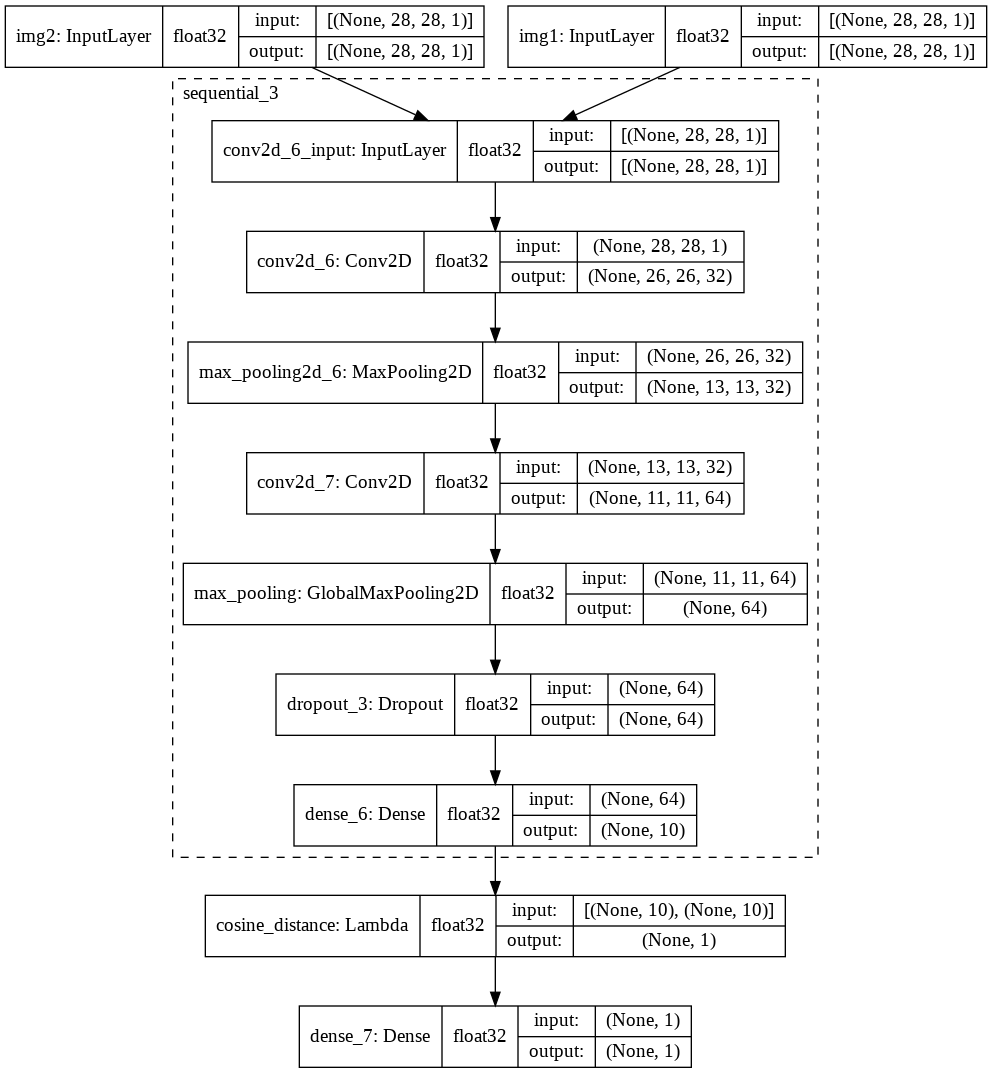

In [ ]:
tf.keras.utils.plot_model(
    model2,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
model2.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),  # clipnorm to avoid gradient explotion
    loss="binary_crossentropy",
    metrics='accuracy'
)

In [ ]:
model2.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/15
704/704 [==============================] - 6s 7ms/step - loss: 0.6837 - accuracy: 0.5165 - val_loss: 0.5637 - val_accuracy: 0.6984
Epoch 2/15
704/704 [==============================] - 5s 7ms/step - loss: 0.5613 - accuracy: 0.6968 - val_loss: 0.4851 - val_accuracy: 0.7614
Epoch 3/15
704/704 [==============================] - 5s 7ms/step - loss: 0.5069 - accuracy: 0.7471 - val_loss: 0.4474 - val_accuracy: 0.7881
Epoch 4/15
704/704 [==============================] - 5s 7ms/step - loss: 0.4784 - accuracy: 0.7661 - val_loss: 0.4114 - val_accuracy: 0.8085
Epoch 5/15
704/704 [==============================] - 5s 7ms/step - loss: 0.4539 - accuracy: 0.7865 - val_loss: 0.3641 - val_accuracy: 0.8407
Epoch 6/15
704/704 [==============================] - 5s 7ms/step - loss: 0.4338 - accuracy: 0.7983 - val_loss: 0.3633 - val_accuracy: 0.8370
Epoch 7/15
704/704 [==============================] - 5s 7ms/step - loss: 0.4196 - accuracy: 0.8089 - val_loss: 0.3437 - val_accuracy: 0.8505
Epoch 

In [ ]:
model2.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)

557/557 [==============================] - 1s 2ms/step - loss: 0.2881 - accuracy: 0.8828


[0.2881358861923218, 0.8828282952308655]

In [ ]:
y_pred = model2.predict([te_pairs[:, 0], te_pairs[:, 1]])

In [ ]:
y_pred[:10]

array([[0.93186516],
       [0.20887312],
       [0.92599875],
       [0.5836812 ],
       [0.80603075],
       [0.07510244],
       [0.85184056],
       [0.27240443],
       [0.8634446 ],
       [0.55358046]], dtype=float32)

## Model3
- Use 3 distances
- Use flatten + max-pooling

In [ ]:
import tensorflow as tf
import math


EPSILON = tf.keras.backend.epsilon()


def l1_distance(vector_pair): 
    x, y = vector_pair
    return tf.norm(x - y, ord=1, axis=1, keepdims=True)

def l2_distance(vector_pair):
    x, y = vector_pair
    return tf.norm(x - y, ord=2, axis=1, keepdims=True)

def cosine_distance(vector_pair):

    x, y = vector_pair

    cos_sim = tf.reduce_sum(
        tf.multiply(
            x,
            y),
#             tf.math.l2_normalize(x, axis=1), 
#             tf.math.l2_normalize(y, axis=1)), 
        axis=1,
        keepdims=True)
    
    cos_sim = tf.clip_by_value(cos_sim, -1.0, 1.0)
    return 1 - cos_sim


In [ ]:
image_1 = keras.Input(shape=(28, 28, 1), name="img1")
image_2 = keras.Input(shape=(28, 28, 1), name="img2")

feature_extractor = keras.Sequential(
    [
        # keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

ref_representation = feature_extractor(image_1)
cand_representation = feature_extractor(image_2)

Cosine_layer = tf.keras.layers.Lambda(cosine_distance, name='cosine_distance')
Cosine_distance = Cosine_layer([cand_representation, ref_representation])

L1_distance_layer = tf.keras.layers.Lambda(l1_distance, name='l1_distance')
L1_distance = L1_distance_layer([cand_representation, ref_representation])

L2_distance_layer = tf.keras.layers.Lambda(l2_distance, name='l2_distance')
L2_distance = L2_distance_layer([cand_representation, ref_representation])

distances_layer = tf.keras.layers.Concatenate()([Cosine_distance, L1_distance, L2_distance])

outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        )(distances_layer)

model3 = tf.keras.Model(
    inputs= [image_1, image_2], 
    outputs=outputs,
)

model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img2 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
img1 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           34826       img1[0][0]                       
                                                                 img2[0][0]                       
__________________________________________________________________________________________________
cosine_distance (Lambda)        (None, 1)            0           sequential_1[1][0]         

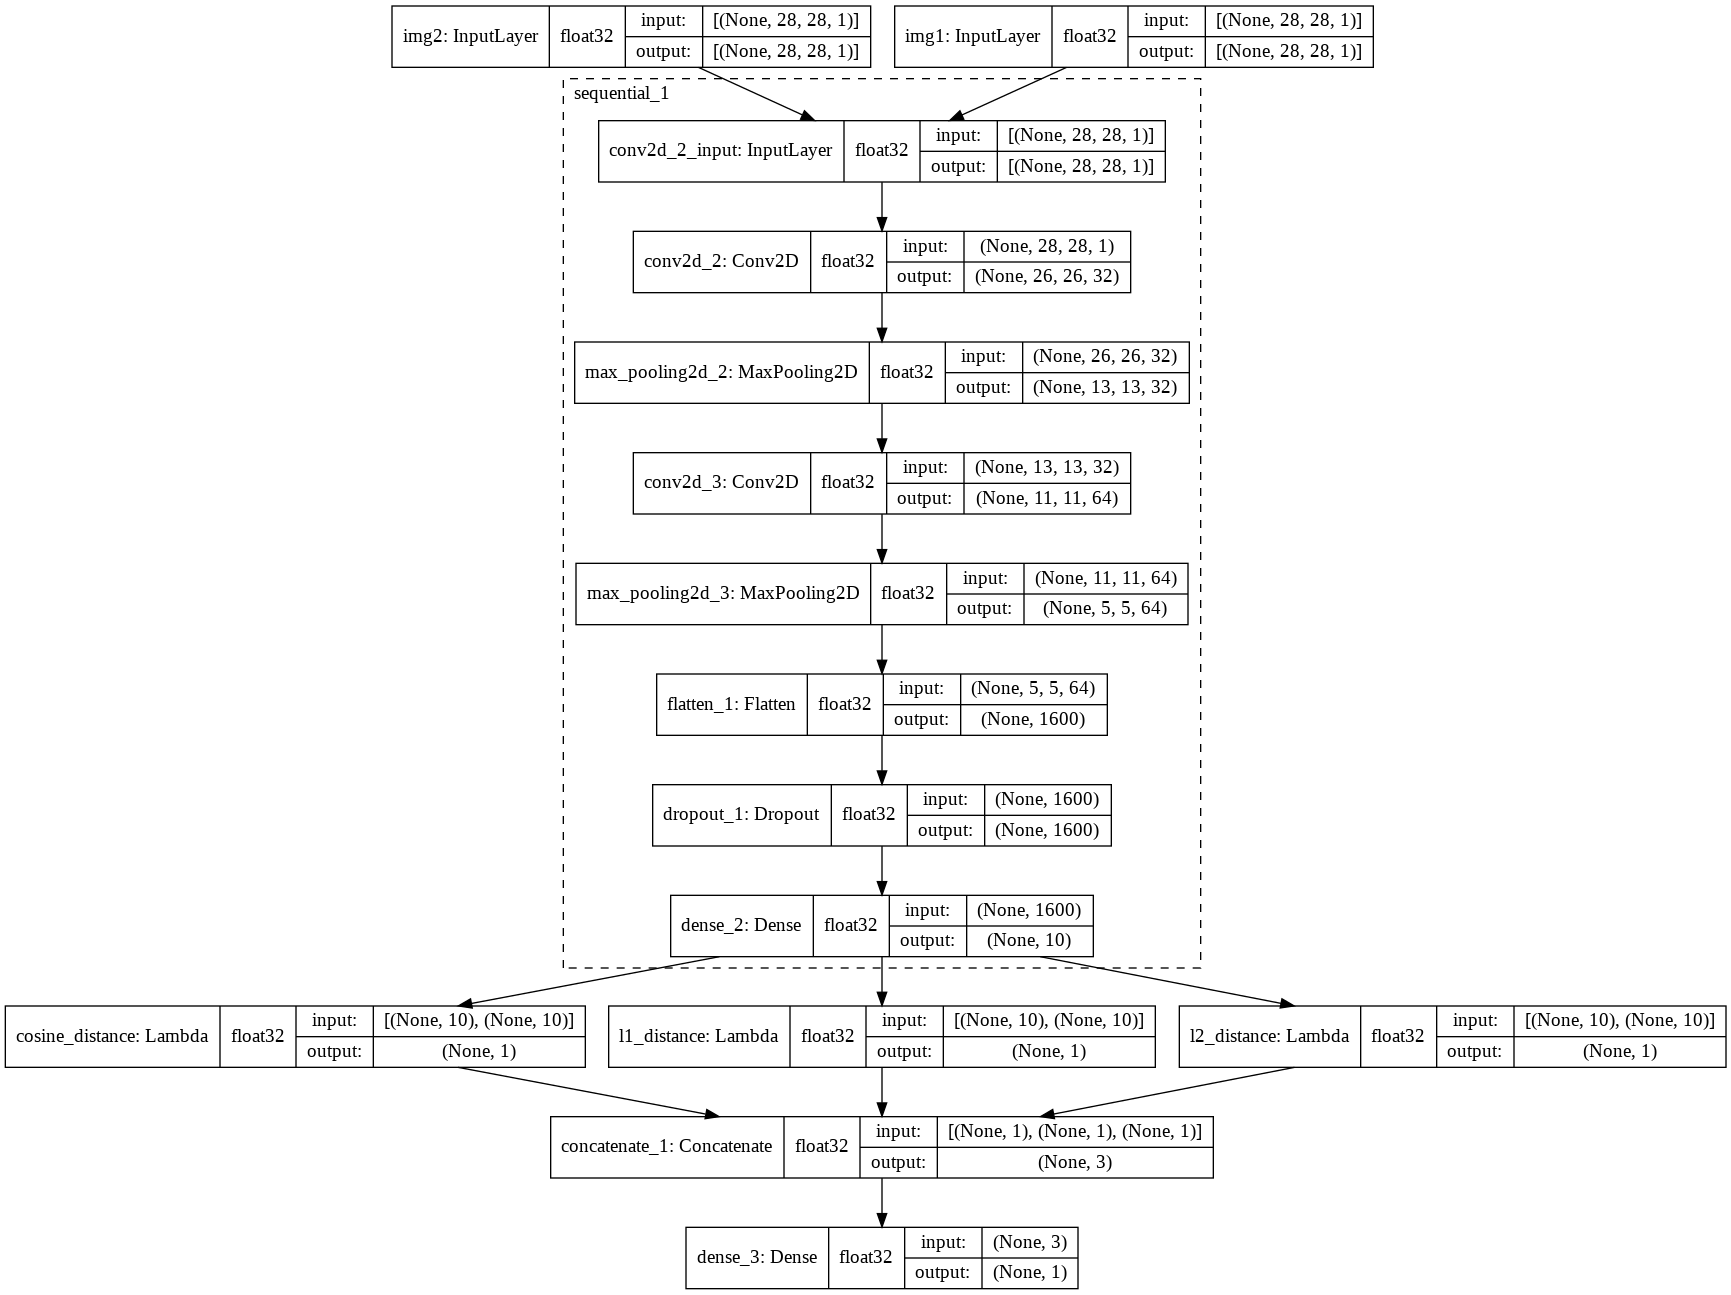

In [ ]:
tf.keras.utils.plot_model(
    model3,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
model3.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),  # clipnorm to avoid gradient explotion
    loss="binary_crossentropy",
    metrics='accuracy'
)

In [ ]:
model3.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/15
704/704 [==============================] - 13s 8ms/step - loss: 0.5594 - accuracy: 0.7013 - val_loss: 0.3392 - val_accuracy: 0.8614
Epoch 2/15
704/704 [==============================] - 5s 7ms/step - loss: 0.3882 - accuracy: 0.8306 - val_loss: 0.2610 - val_accuracy: 0.8963
Epoch 3/15
704/704 [==============================] - 5s 7ms/step - loss: 0.3340 - accuracy: 0.8595 - val_loss: 0.2423 - val_accuracy: 0.9005
Epoch 4/15
704/704 [==============================] - 5s 7ms/step - loss: 0.3112 - accuracy: 0.8694 - val_loss: 0.2809 - val_accuracy: 0.8905
Epoch 5/15
704/704 [==============================] - 5s 7ms/step - loss: 0.2954 - accuracy: 0.8771 - val_loss: 0.2017 - val_accuracy: 0.9216
Epoch 6/15
704/704 [==============================] - 5s 7ms/step - loss: 0.2920 - accuracy: 0.8794 - val_loss: 0.1821 - val_accuracy: 0.9320
Epoch 7/15
704/704 [==============================] - 5s 7ms/step - loss: 0.2467 - accuracy: 0.8996 - val_loss: 0.1863 - val_accuracy: 0.9279
Epoch

In [ ]:
model3.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)

557/557 [==============================] - 1s 2ms/step - loss: 0.1153 - accuracy: 0.9562


[0.11531306803226471, 0.9562289714813232]

# Siamese Network + Contrastive loss

In [ ]:
# import tensorflow as tf
# import math


# EPSILON = tf.keras.backend.epsilon()


# def l1_distance(vector_pair): 
#     x, y = vector_pair
#     return tf.norm(x - y, ord=1, axis=1, keepdims=True)

# def l2_distance(vector_pair):
#     x, y = vector_pair
#     return tf.norm(x - y, ord=2, axis=1, keepdims=True)

# def cosine_distance(vector_pair):

#     x, y = vector_pair

#     cos_sim = tf.reduce_sum(
#         tf.multiply(
#             x,
#             y),
# #             tf.math.l2_normalize(x, axis=1), 
# #             tf.math.l2_normalize(y, axis=1)), 
#         axis=1,
#         keepdims=True)
    
#     cos_sim = tf.clip_by_value(cos_sim, -1.0, 1.0)
#     return 1 - cos_sim


In [ ]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
image_1 = keras.Input(shape=(28, 28, 1), name="img1")
image_2 = keras.Input(shape=(28, 28, 1), name="img2")

feature_extractor = keras.Sequential(
    [
        # keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)

ref_representation = feature_extractor(image_1)
cand_representation = feature_extractor(image_2)

L2_layer = tf.keras.layers.Lambda(l2_distance, name='l2_distance')
L2_distance = L2_layer([cand_representation, ref_representation])

model_contrastive = tf.keras.Model(
    inputs= [image_1, image_2], 
    outputs=L2_distance,
)

model_contrastive.summary()

NameError: ignored

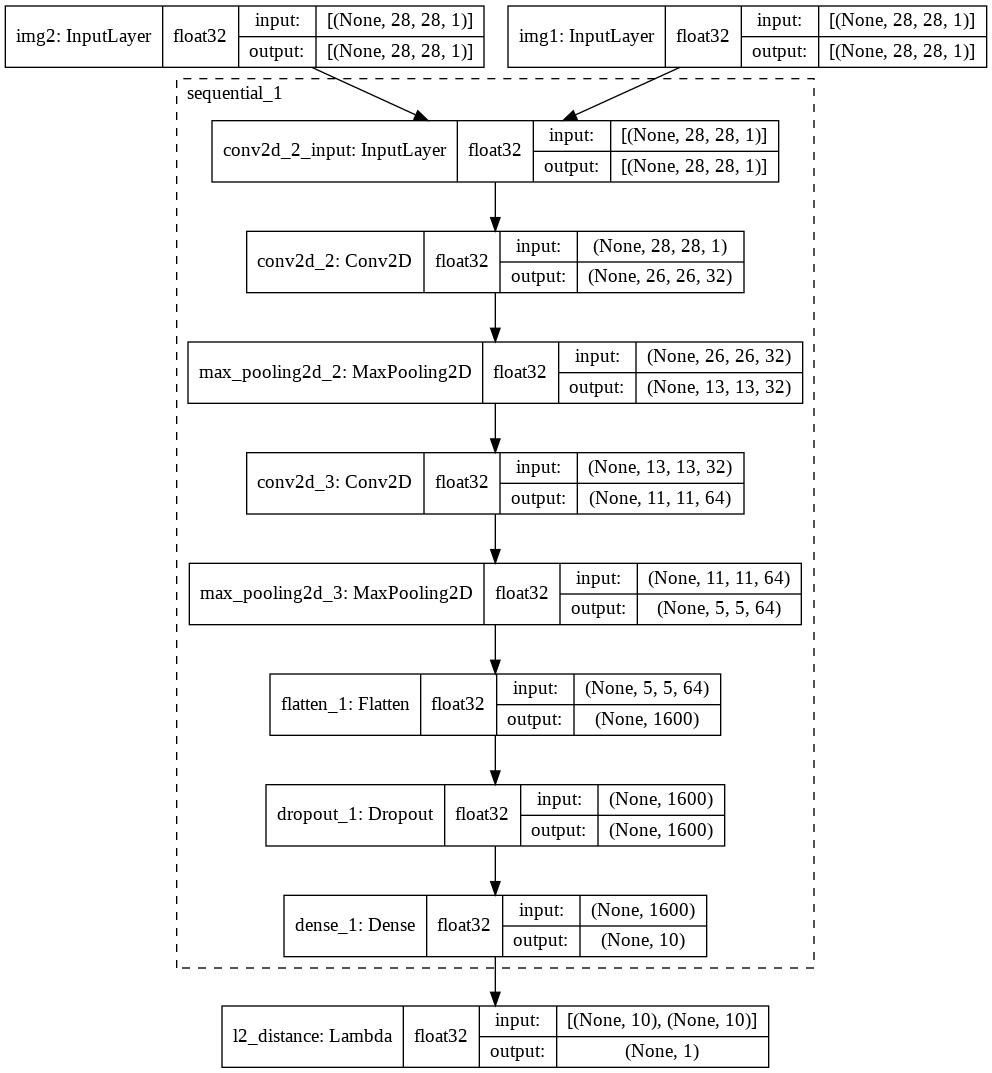

In [ ]:
tf.keras.utils.plot_model(
    model_contrastive,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
def compute_precision(labels, predictions, threhold=0.5):
    """ Compute classification accuracy with a fixed threshold on distances.
    """
    return labels[predictions.ravel() < threhold].mean()

In [ ]:
def compute_acc(labels, predictions, threhold=0.5):
  # labels_pred = predictions.ravel() < threhold
  label_pred = []
  for i in predictions.ravel() < threhold:
    if i:
      label_pred.append(1)
    else:
      label_pred.append(0)
  # import pdb; pdb.set_trace()

  return np.mean(labels == np.array(label_pred))

In [ ]:
# def my_acc(y_true, d):
#   def f1(): return tf.constant(1)
#   def f2(): return tf.constant(0)
#   r = tf.cond(tf.less(y_true - d, 0.5), f1, f2)
#   return tf.reduce_mean(r)
#   # return tf.reduce_mean(y_true - y_pred < 0.5, axis=-1)
#     # squared_difference = tf.square(y_true - y_pred)
#     # return tf.reduce_mean(squared_difference, axis=-1)

In [ ]:
import tensorflow_addons as tfa

model_contrastive.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),  # clipnorm to avoid gradient explotion
    loss=tfa.losses.ContrastiveLoss(),
    metrics=[accuracy]
)

In [ ]:
history = model_contrastive.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/15
704/704 [==============================] - 10s 13ms/step - loss: 0.1441 - accuracy: 0.8137 - val_loss: 0.0770 - val_accuracy: 0.9353
Epoch 2/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1111 - accuracy: 0.8837 - val_loss: 0.0780 - val_accuracy: 0.9477
Epoch 3/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1076 - accuracy: 0.8903 - val_loss: 0.0732 - val_accuracy: 0.9446
Epoch 4/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1078 - accuracy: 0.8895 - val_loss: 0.0737 - val_accuracy: 0.9446
Epoch 5/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1075 - accuracy: 0.8901 - val_loss: 0.0768 - val_accuracy: 0.9432
Epoch 6/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1075 - accuracy: 0.8908 - val_loss: 0.0765 - val_accuracy: 0.9437
Epoch 7/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1085 - accuracy: 0.8902 - val_loss: 0.0746 - val_accuracy: 0.945

In [ ]:
model_contrastive.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/15
704/704 [==============================] - 16s 14ms/step - loss: 0.1407 - val_loss: 0.0751
Epoch 2/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1064 - val_loss: 0.0829
Epoch 3/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1051 - val_loss: 0.0800
Epoch 4/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1045 - val_loss: 0.0728
Epoch 5/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1044 - val_loss: 0.0829
Epoch 6/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1037 - val_loss: 0.0783
Epoch 7/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1026 - val_loss: 0.0722
Epoch 8/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1021 - val_loss: 0.0732
Epoch 9/15
704/704 [==============================] - 9s 13ms/step - loss: 0.1024 - val_loss: 0.0816
Epoch 10/15
704/704 [==============================] - 9s 12ms/step - loss: 0.1025 - val_l

In [ ]:
# model_contrastive.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
#           validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

In [ ]:
y_pred = model_contrastive.predict([te_pairs[:, 0], te_pairs[:, 1]])

In [ ]:
compute_acc(te_y, y_pred)

0.960942760942761

In [ ]:
y_pred = model_contrastive.predict([te_pairs[:, 0], te_pairs[:, 1]])

In [ ]:
def compute_accuracy(predictions, labels):
    """ Compute classification accuracy with a fixed threshold on distances.
    """
    return labels[predictions.ravel() < 0.25].mean()  # so need a smaller margin 

In [ ]:
compute_accuracy(y_pred, te_y)  # margin = 0.25

0.9842242651231415

In [ ]:
# def contrastive_loss(y_true, y_pred):
#   margin = 1
#   y_pred = tf.convert_to_tensor(y_pred)
#   y_true = tf.dtypes.cast(y_true, y_pred.dtype)
  # return tf.reduce_mean(y_true * tf.math.square(y_pred) + (1.0 - y_true) * tf.math.square(
  #         tf.math.maximum(margin - y_pred, 0.0))
  #     )

# # def contrastive_loss(y, d):
# #     """ Contrastive loss from Hadsell-et-al.'06
# #         http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
# #     """
# #     margin = 1
# #     d = tf.convert_to_tensor(d)
# #     y = tf.dtypes.cast(y, d.dtype)
# #     return np.mean(y * d**2 + (1 - y) * (max(margin - d, 0)**2))


In [ ]:
# model_contrastive.compile(
#     tf.keras.optimizers.Adam(learning_rate=0.01),
#     contrastive_loss,
#     metrics='accuracy'
# )

In [ ]:
# model_contrastive.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, epochs=15,
#           validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

# Subclass model

In [ ]:
from typing import Any, List, Optional, Union

import tensorflow as tf

# from metrics import l2_distance, angular_distance

class MLP(tf.keras.layers.Layer):
    # ref: https://github.com/google-research/simclr/blob/master/tf2/model.py#L119
    def __init__(
        self,
        hidden_dims: List[int],
        dropout_rate: Union[None, float],
        activation: Optional[str] = "relu",
        use_bn: bool = True,
        **kwargs: Any,
    ):
        super(MLP, self).__init__(**kwargs)
        
        self.dropout_rate = dropout_rate
        self.num_layers = len(hidden_dims)
        self.hidden_layers = []
        self.use_bn = use_bn
    
        if self.num_layers >= 2:
            self.hidden_layers = [
                tf.keras.layers.Dense(hidden_dim, activation=activation)
                for hidden_dim in hidden_dims[:-1]
            ]
        self.hidden_layers.append(tf.keras.layers.Dense(hidden_dims[-1], use_bias=False, activation=None))


    def call(self, inputs: Any, training: Optional[Union[bool, None]] = None) -> Any:
        h = inputs

        for idx, hidden_layer in enumerate(self.hidden_layers):
            h = hidden_layer(h)
            if training:
                if self.rate:
                    h = tf.nn.dropout(h, rate=self.dropout_rate)
                if idx != self.num_layers - 1 and self.use_bn:
                    h = tf.keras.layers.BatchNormalization(trainable=True)
            else:
                if idx != self.num_layers - 1 and self.use_bn:
                    h = tf.keras.layers.BatchNormalization(trainable=False)

        h = tf.math.l2_normalize(h, axis=1)

        return h

class MobileNetFeatureExtractor(tf.keras.Model):
    def __init__(self, input_shape=(28, 28, 1)):
        super().__init__()
        self.model = tf.keras.applications.MobileNetV2(
            weights="imagenet", include_top=False, pooling="avg", input_shape=input_shape,
        )
        self.mlp = MLP(hidden_dims=[128*2, 128], dropout_rate=0.5)

    def call(self, inputs, training: Optional[Union[bool, None]] = None):
        product = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
        product = self.model(product)
        product = self.mlp(product, training=training)


class SiameseNetwork(tf.keras.Model):
    def __init__(self) -> None:
        super().__init__()
        self.feature_extractor = MobileNetFeatureExtractor()

    def call(self, inputs, training: Optional[Union[bool, None]] = None):
        reference_emb = self.feature_extractor(inputs["reference_image"], training=training)
        candidate_emb = self.feature_extractor(inputs["candidate_image"], training=training)
        
        return 1.0 - angular_distance([reference_emb, candidate_emb])

In [ ]:
model = SiameseNetwork()

ValueError: ignored

ValueError: ignored